In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/sphere_r=300_mesh_90nm.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.61%

Calculate measures for tri type of elements
Progress: 99.78%

Calculate measures for tet type of elements
Progress: 99.96%

Calculation of measures of all elements finished in 16.49298071861267 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T
elements = mesh.elements_coordinates
len(centers.T)

2634

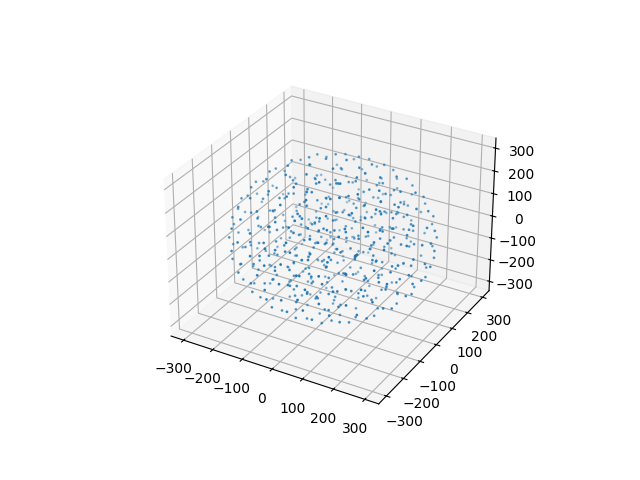

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [7]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [8]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/sphere_r=300_magnetization_90nm.txt",
    mesh=mesh,
    dim=3)

In [9]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_
del M0

Begin placement of operator on mesh elements' centers.
Progress: 99.96%

Mesh matric of the operator generated in 3.7558822631835938 seconds.


In [10]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.96%

Mesh matric of the operator generated in 603.5996508598328 seconds.


In [12]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/sphere_r=300_H_eff_90nm.txt",
    mesh=mesh,
    dim=3)

"""_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T"""

'_H_eff = H_eff.vectorize()\nvals_H_eff = H_eff.values.T'

In [13]:
"""%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    vals_H_eff[0],
    vals_H_eff[1],
    vals_H_eff[2],
    length=0.001,
)

plt.show()"""

'%matplotlib inline\n%matplotlib widget \n\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib.pyplot as plt\nimport numpy as np\n\nfig = plt.figure(figsize=(5,5), dpi=100)\nax = fig.add_subplot(projection="3d") \n\nax.quiver(\n    centers[0],\n    centers[1],\n    centers[2],\n    vals_H_eff[0],\n    vals_H_eff[1],\n    vals_H_eff[2],\n    length=0.001,\n)\n\nplt.show()'

In [14]:
H_eff_cpo = CPO(
    mesh=mesh,
    left_vector=H_eff
)
H_eff_times_ = H_eff_cpo.to_mesh_matrix()
del H_eff

Begin placement of operator on mesh elements' centers.
Progress: 99.96%

Mesh matric of the operator generated in 3.3914968967437744 seconds.


In [31]:
IntConvOp = matmul(M0_times_,int_G_)

In [32]:
LLG_operator = 1j * gamms * (H_eff_times_ - M_s * IntConvOp)

del IntConvOp
LLG_operator

: 

In [30]:
omega_char = gamms * 5e6
null_LLG = LLG_operator - omega_char * np.identity(n=len(LLG_operator))
null_LLG

/tmp/ipykernel_16836/2624380885.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  null_LLG = LLG_operator - omega_char * np.identity(n=len(LLG_operator))


tensor([[-1.1250e+11-2.6419e+07j,  0.0000e+00+1.3181e+09j,
          0.0000e+00+2.7179e+08j,  ...,
         -0.0000e+00-5.3264e+05j, -0.0000e+00-2.2602e+05j,
          0.0000e+00+8.7650e+04j],
        [-0.0000e+00-1.2350e+09j, -1.1250e+11+2.6406e+07j,
         -0.0000e+00-2.9625e+08j,  ...,
          0.0000e+00+1.2190e+05j,  0.0000e+00+5.3263e+05j,
         -0.0000e+00-7.9557e+04j],
        [ 0.0000e+00+1.8690e+06j, -0.0000e+00-5.8511e+04j,
         -1.1250e+11+1.2704e+04j,  ...,
         -0.0000e+00-2.9410e+01j, -0.0000e+00-7.5289e+00j,
          0.0000e+00+4.2271e+00j],
        ...,
        [-0.0000e+00-6.2142e+05j, -0.0000e+00-2.6172e+05j,
          0.0000e+00+1.0362e+05j,  ...,
         -1.1250e+11+4.6741e+08j,  0.0000e+00+1.3240e+09j,
          0.0000e+00+3.6173e+08j],
        [ 0.0000e+00+1.4454e+05j,  0.0000e+00+6.2143e+05j,
         -0.0000e+00-9.4247e+04j,  ...,
         -0.0000e+00-1.3872e+09j, -1.1250e+11-4.6739e+08j,
         -0.0000e+00-9.1239e+07j],
        [ 0.0000e+00+2

In [27]:
from scipy.sparse.linalg import eigs as speigs

eigs = speigs(np.array(LLG_operator), k=5, tol=1e-9)

/tmp/ipykernel_16836/2937558820.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  eigs = eigs(np.array(LLG_operator), k=5, tol=1e-6)


In [28]:
eigs

(array([-6.87538910e+00-7.60054990e+09j,  3.69383151e+01-7.55810753e+09j,
        -1.99152639e+07+7.59189631e+09j,  1.99152639e+07+7.59189631e+09j,
         3.80681862e+00+7.35619743e+09j]),
 array([[-7.49872622e-04-2.25081954e-04j,  6.67673875e-04-9.11809917e-05j,
         -7.90507841e-04-1.96278814e-03j, -1.16025888e-03+1.76953080e-03j,
          2.07081255e-03-3.33632764e-04j],
        [ 6.71751909e-03+2.01633324e-03j, -3.48075766e-03+4.75344194e-04j,
          1.14506931e-03+5.59715087e-04j,  1.23263274e-03-3.24162391e-04j,
         -1.01540428e-05+1.64111016e-06j],
        [ 3.30803607e-07+9.92939970e-08j, -2.25772438e-07+3.08332803e-08j,
         -2.51423196e-07-6.03470864e-07j, -3.64942516e-07+5.42409127e-07j,
          6.49431700e-07-1.04632164e-07j],
        ...,
        [ 3.77054382e-03+1.13176865e-03j,  2.10486710e-03-2.87458089e-04j,
          1.27511962e-02-3.38326875e-03j,  1.18395114e-02+5.81940558e-03j,
         -8.06776498e-03+1.29975005e-03j],
        [-6.37069275e-03

In [18]:
eigenvalues = eigs.eigenvalues
eigenvectors = eigs.eigenvectors.T
#eigenvalues = (1j * np.array(eigenvalues))
eigenvalues_idx = np.where(abs(eigenvalues.imag) < 10000000)[0]
eigenvalues = eigenvalues[eigenvalues_idx].real
eigenvalues_idx = np.where(abs(eigenvalues) > 1e9)[0]
eigenvalues = eigenvalues[eigenvalues_idx]
eigenvalues, eigenvalues_idx

(tensor([-2.6998e+09,  2.6998e+09, -2.4134e+09,  2.4134e+09, -2.3212e+09,
          2.3212e+09, -2.2436e+09, -2.2136e+09,  2.2436e+09, -2.1897e+09,
          2.2136e+09, -2.1558e+09,  2.1897e+09,  2.1558e+09,  2.1364e+09,
          2.1170e+09, -2.1364e+09, -2.1170e+09,  2.0753e+09,  2.0715e+09,
         -2.0753e+09, -2.0715e+09, -2.0316e+09, -2.0113e+09,  2.0316e+09,
         -1.9845e+09,  2.0113e+09,  1.9845e+09,  1.9459e+09,  1.9332e+09,
         -1.9459e+09, -1.9332e+09, -1.9028e+09, -1.8866e+09, -1.8751e+09,
         -1.8663e+09,  1.9028e+09,  1.8866e+09,  1.8751e+09,  1.8663e+09,
          1.8485e+09, -1.8485e+09, -1.8150e+09,  1.8150e+09,  1.8029e+09,
         -1.8029e+09, -1.7780e+09,  1.7780e+09,  1.7530e+09, -1.7530e+09,
          1.6957e+09, -1.6957e+09, -1.6750e+09, -1.6682e+09,  1.6750e+09,
          1.6682e+09, -1.6531e+09,  1.6531e+09, -1.6257e+09,  1.6257e+09,
         -1.6147e+09,  1.6147e+09, -1.5991e+09,  1.5991e+09, -1.5631e+09,
          1.5631e+09, -1.5408e+09,  1.

In [23]:
dm = VectorField(
    mesh=mesh,
    coordinates=mesh.elements_centers['tet'],
)
n = 1
_dm = eigenvectors[60] #+ eigenvectors[1]
dm.devectorize(np.array(_dm).real)

dm_values = dm.values.T
dm_coordinates = dm.coorrdinates.T

/tmp/ipykernel_16836/2948338917.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dm.devectorize(np.array(_dm).real)


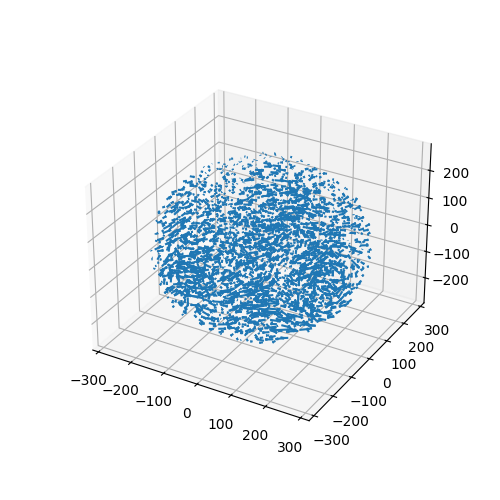

In [24]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    dm_coordinates[0],
    dm_coordinates[1],
    dm_coordinates[2],
    dm_values[0],
    dm_values[1],
    dm_values[2],
    length=900,
)

plt.show()

In [ ]:
eigenvalues[0]

In [ ]:
5e5 * gamms